Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
import seaborn as sns
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords

Read files with subtitles from Donald Trump speeches

In [3]:
trump1 = pd.read_csv("DONALD TRUMP SPEECHES & PRESS CONFERENCE_basic.csv", header=0, delimiter="\~", quoting=3, engine='python')
trump2 = pd.read_csv("Trump TV Network_basic.csv", header=0, delimiter="\~", quoting=3, engine='python')

In [4]:
print(trump1.columns)
print(trump1.head())

Index(['id', 'uploader', 'upload_date', 'title', 'view_count',
       'average_rating', 'like_count', 'dislike_count', 'subtitles'],
      dtype='object')
            id                                  uploader  upload_date  \
0  B84byaqgpIg  DONALD TRUMP SPEECHES & PRESS CONFERENCE     20161027   
1  bhT3xq4mZkE  DONALD TRUMP SPEECHES & PRESS CONFERENCE     20161020   
2  bKMuRFTpdRE  DONALD TRUMP SPEECHES & PRESS CONFERENCE     20160901   
3  BLcXauMl3mY  DONALD TRUMP SPEECHES & PRESS CONFERENCE     20161104   
4  BLulODCrMks  DONALD TRUMP SPEECHES & PRESS CONFERENCE     20160913   

                                               title  view_count  \
0  Full Speech: Donald Trump Rally in Toledo, Ohi...     25266.0   
1  Full Speech: Donald Trump Rally in Delaware, O...     16474.0   
2  Full Speech: Donald Trump Rally in Wilmington,...     38038.0   
3  Full Speech: Donald Trump MASSIVE Rally in Wil...     12641.0   
4  Full Speech: Donald & Ivanka Trump Unveil Chil...     20584.0  

Let's browse some subtitles with a word cloud

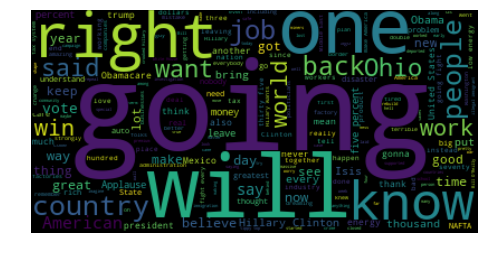

In [5]:
subtitles1 = trump1['subtitles'][0]
wordcloud = WordCloud().generate(subtitles1)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#print(subtitles1)

Let's remove the stopwords and look at word cloud 
(following: https://www.kaggle.com/focusfocus/bag-of-words-to-predict-the-scores/notebook)

Number of words:  4589
Number of stop words:  2118


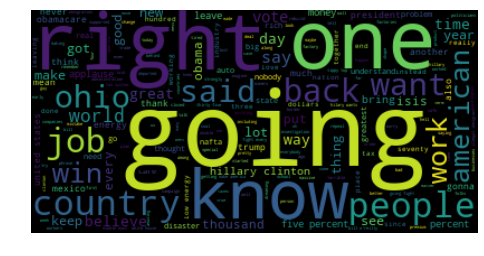

In [10]:
subtitles1 = BeautifulSoup(trump1['subtitles'][0], "html5lib")
lower_case = subtitles1.get_text().lower() 
words = lower_case.split()
print('Number of words: ',len(words))
words_meaningful = [w for w in words if not w in stopwords.words("english")]
words_stopwords = [w for w in words if w in stopwords.words("english")]
print('Number of stop words: ', len(words_stopwords))

subtitles1_clean = " ".join(words_meaningful)
wordcloud = WordCloud().generate(subtitles1_clean)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#print(subtitles1_clean)

A quick look at word cloud of the removed stop words

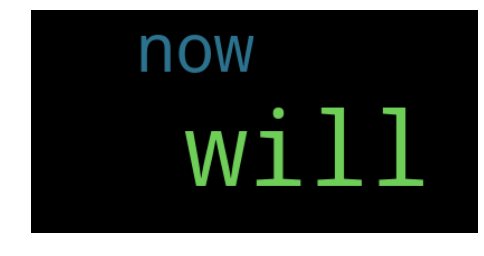

In [12]:
wordcloud = WordCloud().generate(" ".join(words_stopwords))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#print(words_stopwords)

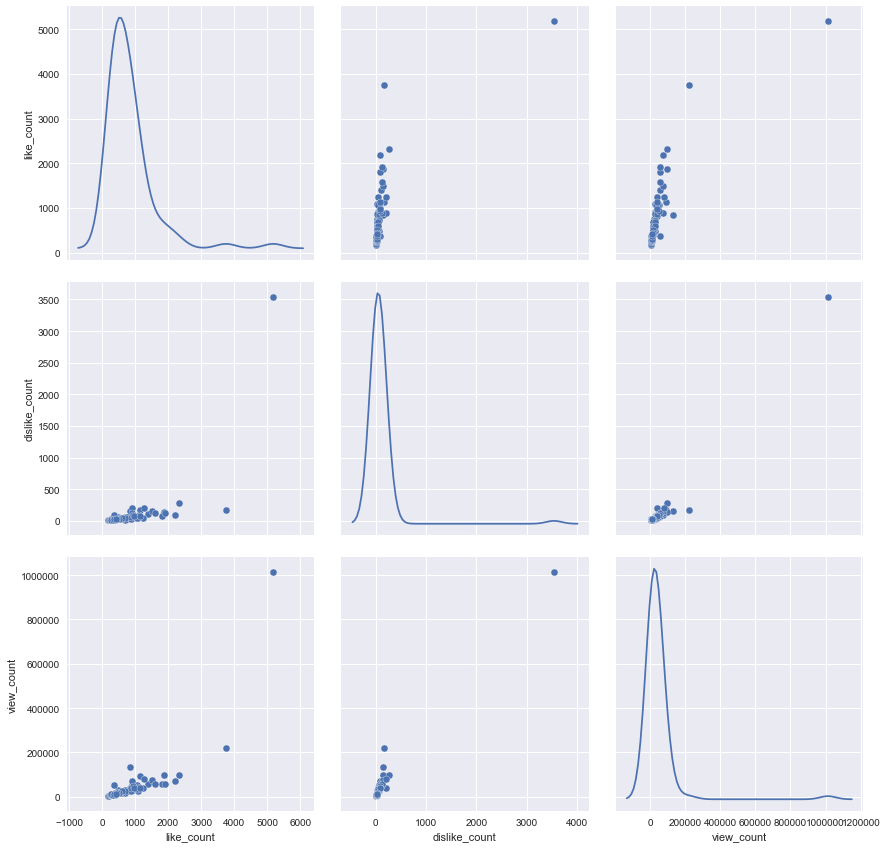

In [13]:
g = sns.pairplot(trump1[['like_count','dislike_count','view_count']], palette='husl', diag_kind='kde',size=4)
plt.show()

Let's remove couple of outliers based on view_count

In [14]:
trump1_clean = trump1[trump1['view_count']<200000]
print(trump1.shape, trump1_clean.shape)

trump2_clean = trump2[trump2['view_count']<100000]
print(trump2.shape, trump2_clean.shape)

(85, 9) (83, 9)
(77, 9) (74, 9)


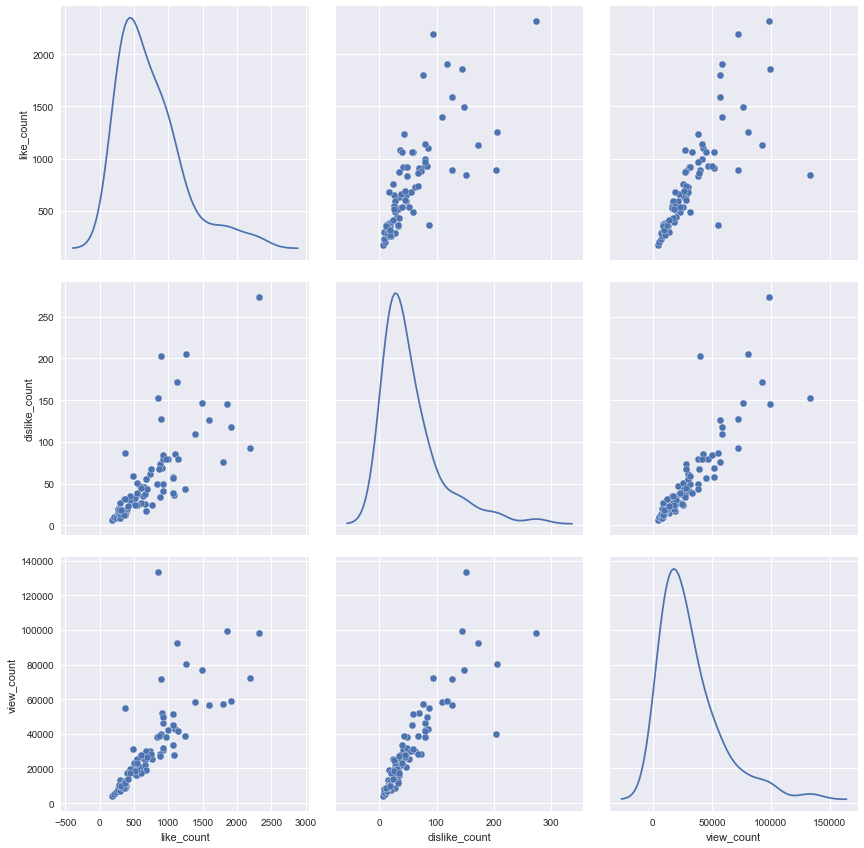

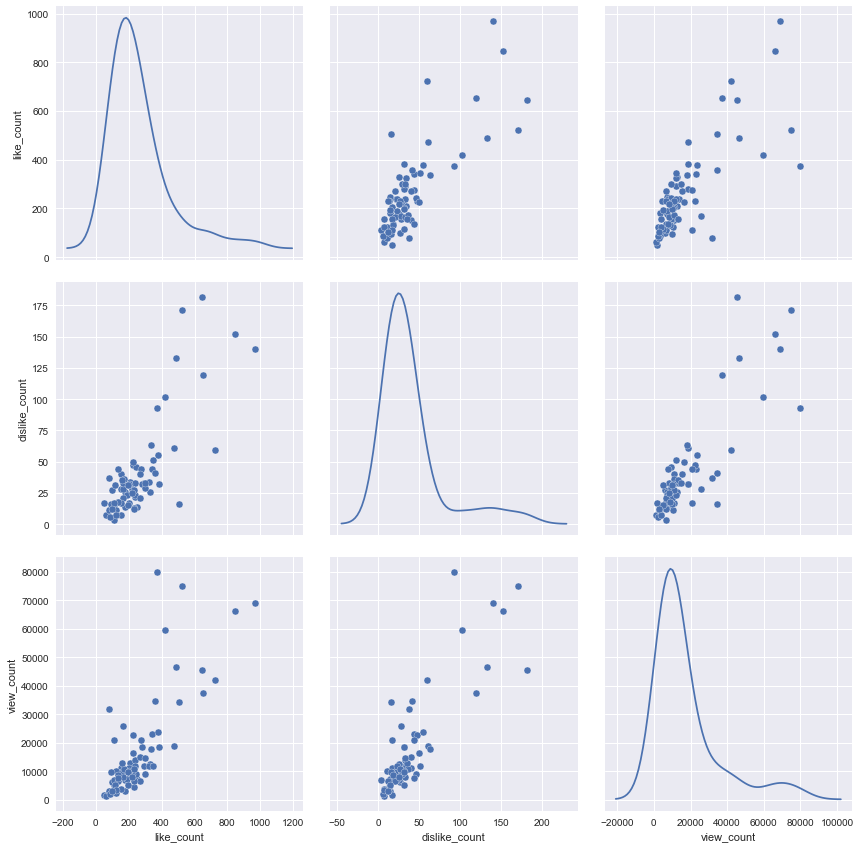

In [15]:
g = sns.pairplot(trump1_clean[['like_count','dislike_count','view_count']], palette='husl', diag_kind='kde',size=4)
plt.show()
g = sns.pairplot(trump2_clean[['like_count','dislike_count','view_count']], palette='husl', diag_kind='kde',size=4)
plt.show()

There's some kind of bit skew distribution of likes, dislikes and views
with linear-like relation between all pair-wise

Let's look at empirical distribution of like_count

median:  633.0
mean:  818.729411765
max:  5177.0
min:  176.0


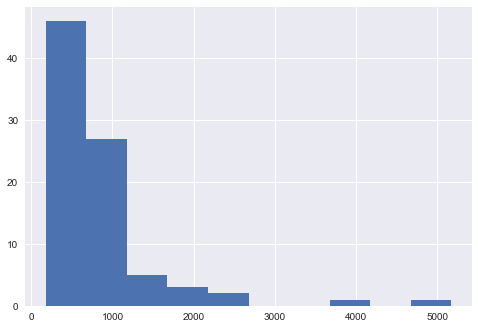

In [16]:

print('median: ',stats.median(trump1['like_count']))
print('mean: ',stats.mean(trump1['like_count']))
print('max: ',max(trump1['like_count']))
print('min: ',min(trump1['like_count']))


plt.hist(trump1['like_count'])
plt.show()

We create like_ratio = like_count / dislike_count, which is sort of distributed around 15 and 7 for respetive sets. Let's assume a video is popular if the like_ratio is above 10 and unpopular otherwise

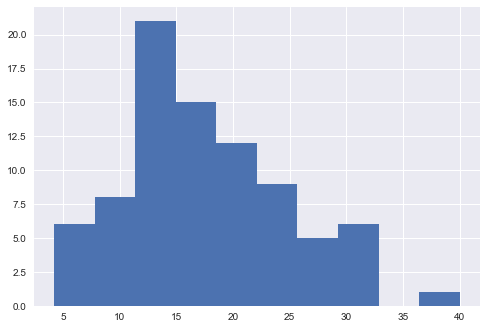

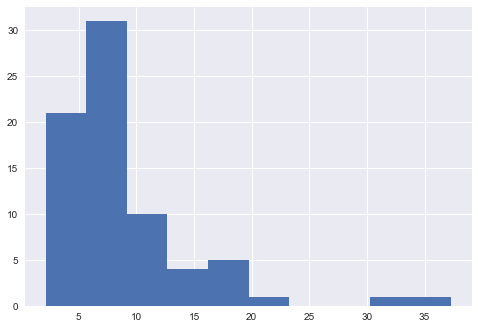

In [17]:
data_train=trump1_clean
data_test=trump2_clean
def calc_popularity(df, popularity_threshold):
    #calculate popularity (0 or 1) based on ratio of likes and dislikes
    #if the ratio is above given threshold assume popularity=1
    like_ratio = np.divide(df['like_count'], df['dislike_count'])
    popularity = like_ratio.apply(lambda x: 1 if popularity_threshold <= x else 0)
    #create dataframe with 3 columns, video_id, popularity and subtitles
    output = df.filter(['id', 'like_count', 'subtitles' ], axis=1)
    output = output.rename(index=str, columns={'like_count' : 'popularity'})
    output['popularity'] = popularity.values
    return output, like_ratio

train, like_ratio1 = calc_popularity(data_train, popularity_threshold = 10)    
test, like_ratio2  = calc_popularity(data_test, popularity_threshold = 10) 

plt.hist(like_ratio1)
plt.show()
plt.hist(like_ratio2)
plt.show()


Following code from https://www.kaggle.com/focusfocus/bag-of-words-to-predict-the-scores/notebook
let's try Adaboost

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df=1)
#train_sample = train.sample(frac = 1, random_state=87824, axis=0)
train_sample = train

# learn the vocabulary and transform the data set into feature vectors
sample_features = vect.fit_transform(train_sample['subtitles'])

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score
ab = AdaBoostClassifier(n_estimators=7)

column = 'popularity'


ab.fit(sample_features, train_sample[column])

#test_sample = test.sample(frac = 1.0, random_state=824, axis=0)
test_sample = test
preds = ab.predict(vect.transform(test_sample['subtitles']))

print('Accuracy: ' + str( 100*sum(preds == test_sample[column].values)/len(preds) ) + '%')
print('F1      : ' + str(f1_score(test_sample[column],preds, average='micro')))

Accuracy: 39.1891891892%
F1      : 0.391891891892


Let's try again without the stop words
(borrowing from https://www.kaggle.com/focusfocus/bag-of-words-to-predict-the-scores/notebook)

We are removing stop words from subtitles and saving new data as *_nostop dataframe

In [19]:
def subtitles_to_words( raw_text ):
    text = BeautifulSoup(raw_text,"html5lib").get_text() 
    words = text.lower().split()                             
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]   
    return( " ".join( meaningful_words ))   

num_subtitles = train["subtitles"].size
clean_train_subtitles = []
for i in range( 0, num_subtitles ):
    if( (i+1)%10 == 0 ):
        print("Subtitles text %d of %d" % ( i+1, num_subtitles ) )                                                                   
    clean_train_subtitles.append( subtitles_to_words( train["subtitles"][i] ))


#print(type(train['subtitles']))
#print(type(clean_train_subtitles))
#print(train.head())

train_nostop = train.filter(['id', 'popularity', 'subtitles' ], axis=1)
train_nostop['subtitles'] = clean_train_subtitles
#print(train_nostop.head())

Subtitles text 10 of 83
Subtitles text 20 of 83
Subtitles text 30 of 83
Subtitles text 40 of 83
Subtitles text 50 of 83
Subtitles text 60 of 83
Subtitles text 70 of 83
Subtitles text 80 of 83


Same for the test set

In [20]:
num_subtitles = test["subtitles"].size
clean_test_subtitles = []
for i in range( 0, num_subtitles ):
    if( (i+1)%10 == 0 ):
        print("Subtitles text %d of %d" % ( i+1, num_subtitles ) )                                                                   
    clean_test_subtitles.append( subtitles_to_words( test["subtitles"][i] ))

#print(type(test['subtitles']))
#print(type(clean_test_subtitles))
#print(test.head())

test_nostop = test.filter(['id', 'popularity', 'subtitles' ], axis=1)
test_nostop['subtitles'] = clean_test_subtitles

Subtitles text 10 of 74
Subtitles text 20 of 74
Subtitles text 30 of 74
Subtitles text 40 of 74
Subtitles text 50 of 74
Subtitles text 60 of 74
Subtitles text 70 of 74


Train Adaboost model again

In [21]:
vect = CountVectorizer(min_df=1)
#train_sample = train_nostop.sample(frac = 1.0, random_state=87824, axis=0)
train_sample = train_nostop
sample_features = vect.fit_transform(train_sample['subtitles'])
ab = AdaBoostClassifier(n_estimators=7)

column = 'popularity'
ab.fit(sample_features, train_sample[column])

#test_sample = test_nostop.sample(frac = 1.0, random_state=824, axis=0)
test_sample = test_nostop
preds = ab.predict(vect.transform(test_sample['subtitles']))

print('Accuracy: ' + str( 100*sum(preds == test_sample[column].values)/len(preds) ) + '%')
print('F1      : ' + str(f1_score(test_sample[column],preds, average='micro')))

Accuracy: 32.4324324324%
F1      : 0.324324324324
